<a href="https://colab.research.google.com/github/SanjibSarkarU/colab-NN/blob/main/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*DNN *

In [2]:
!pip install tensorflow-gpu

     |████████████████████████████████| 497.5 MB 26 kB/s 
     |████████████████████████████████| 462 kB 45.6 MB/s 


In [3]:
from google.colab import files
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
uploaded = files.upload()


In [4]:
import pandas as pd

In [6]:
df = pd.read_csv('20220222_153859_hlc.csv', skiprows=1)
df = df.rename(columns={"Latitude (Deg N)": 'lat', "Longitude (Deg W)": 'lng'}, errors="raise")

In [7]:
df.head(5)

,Date (mm/dd/yyyy),Time,Num Satellites,Position Uncertainty (m),lat,lng,Speed (kts),Heading (Deg N),Course (Deg N),OCB Temp (C),...,charge (%) port,StatorTemp (C) port,PCBTep (C) port,Error Code port,Volts stbd,Amps stbd,charge (%) stbd,StatorTemp (C) stbd,PCBTep (C) stbd,Error Code stbd
0,02/22/2022,15:38:59.199,0,0,0.0,0.0,-0.0,136.0,0.0,43.3,...,0.0,0.0,0.0,0x0,0.0,0.0,0.0,0.0,0.0,0x0
1,02/22/2022,15:39:00.198,0,0,0.0,0.0,-0.0,136.3,0.0,43.6,...,0.0,0.0,0.0,0x0,0.0,0.0,0.0,0.0,0.0,0x0
2,02/22/2022,15:39:01.199,0,0,0.0,0.0,-0.0,136.5,0.0,43.3,...,0.0,0.0,0.0,0x0,0.0,0.0,0.0,0.0,0.0,0x0
3,02/22/2022,15:39:02.198,0,0,0.0,0.0,-0.0,136.7,0.0,43.2,...,0.0,0.0,0.0,0x0,0.0,0.0,0.0,0.0,0.0,0x0
4,02/22/2022,15:39:03.199,0,0,0.0,0.0,-0.0,137.4,0.0,43.3,...,0.0,0.0,0.0,0x0,0.0,0.0,0.0,0.0,0.0,0x0


In [7]:
# Delete the row if lat column has zero 
df = df.loc[(df['lat'] != 0)]

In [ ]:
df.head(5)

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [10]:
window_size = 15
batch_size = 32
shuffle_buffer_size = 100

In [11]:
# training and validation
split_time = 3900
time_train = series_time[:split_time]
x_train_lat = series_lat[:split_time]
x_train_lng = series_lng[:split_time]

time_valid = series_time[split_time:]
x_valid_lat = series_lat[split_time:]
x_valid_lng = series_lng[split_time:]
print(f'total: {len(series_lat)}, x_train_lat:{len(x_train_lat)}, x_valid_lat:{len(x_valid_lat)}')


total: 5200, x_train_lat:3900, x_valid_lat:1300


In [26]:
dataset = windowed_dataset(x_valid_lat,window_size, batch_size, shuffle_buffer_size)
[data for data in dataset]

[(<tf.Tensor: shape=(32, 15), dtype=float64, numpy=
  array([[30.35204947, 30.35204705, 30.35204774, 30.3520489 , 30.35205041,
          30.35204914, 30.3520451 , 30.35203883, 30.35203111, 30.35202314,
          30.35202009, 30.35201745, 30.35201601, 30.35201478, 30.35201428],
         [30.35207917, 30.35207351, 30.3520672 , 30.35205989, 30.35204947,
          30.35204705, 30.35204774, 30.3520489 , 30.35205041, 30.35204914,
          30.3520451 , 30.35203883, 30.35203111, 30.35202314, 30.35202009],
         [30.35227355, 30.35225036, 30.35223744, 30.35222578, 30.35221434,
          30.35220517, 30.35219715, 30.35219165, 30.35218674, 30.35218041,
          30.35216272, 30.3521526 , 30.35214363, 30.35213621, 30.35213245],
         [30.35241987, 30.35240391, 30.3523896 , 30.35237489, 30.35236313,
          30.35234509, 30.35233727, 30.35232962, 30.35232161, 30.35231329,
          30.35230403, 30.35229486, 30.35228403, 30.35227355, 30.35225036],
         [30.35201587, 30.3520168 , 30.35201

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


In [14]:
forecast_lat = []
for time in range(len(series_lat) - window_size):  
  forecast_lat.append(model.predict(series_lat[time:time + window_size][np.newaxis]))

forecast_lat = forecast_lat[split_time - window_size:]
results_lat = np.array(forecast_lat)[:, 0, 0]

In [15]:
print([x for x in forecast_lat])

[array([[30.35249]], dtype=float32), array([[30.352486]], dtype=float32), array([[30.352482]], dtype=float32), array([[30.352474]], dtype=float32), array([[30.352474]], dtype=float32), array([[30.35247]], dtype=float32), array([[30.352474]], dtype=float32), array([[30.35247]], dtype=float32), array([[30.35247]], dtype=float32), array([[30.35247]], dtype=float32), array([[30.352463]], dtype=float32), array([[30.352459]], dtype=float32), array([[30.352455]], dtype=float32), array([[30.352442]], dtype=float32), array([[30.352432]], dtype=float32), array([[30.352425]], dtype=float32), array([[30.35241]], dtype=float32), array([[30.352392]], dtype=float32), array([[30.352379]], dtype=float32), array([[30.352367]], dtype=float32), array([[30.352356]], dtype=float32), array([[30.35234]], dtype=float32), array([[30.35233]], dtype=float32), array([[30.352318]], dtype=float32), array([[30.352314]], dtype=float32), array([[30.352295]], dtype=float32), array([[30.352283]], dtype=float32), array([[

In [16]:
print(results_lat)

[30.35249  30.352486 30.352482 ... 30.351545 30.35155  30.351553]


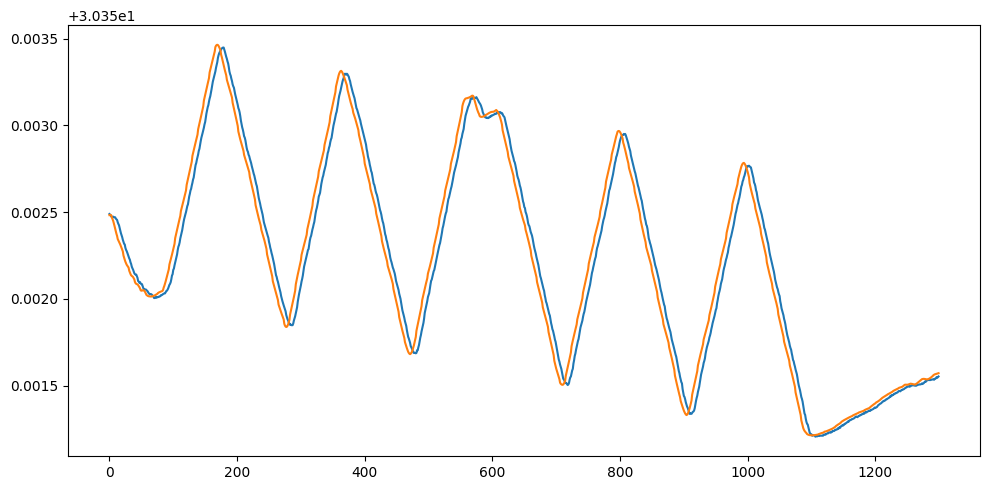

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10, 5), tight_layout=True, dpi=100)
xaxis = [y for y in range(len(results_lat))]
ax.plot(xaxis, results_lat)
ax.plot(xaxis, x_valid_lat)

In [18]:
start = 8500
end = 13700
series_time = df.Time[start:end]
series_lat = df.lat[start:end]
series_lng = df.lng[start:end]

coordinates = [(i,j) for i,j in zip(series_lat, series_lng)]
coordinates= np.array(coordinates, dtype =np.float64)
print(type(coordinates))
print(coordinates)

# series_time = series_time.to_numpy()
series_lat = series_lat.to_numpy()
# series_lng = series_lng.to_numpy()



<class 'numpy.ndarray'>
[[ 30.35165497 -89.62907355]
 [ 30.35165452 -89.62907351]
 [ 30.35165437 -89.62907359]
 ...
 [ 30.35157004 -89.62766099]
 [ 30.35157101 -89.62765514]
 [ 30.35157185 -89.62764892]]


In [19]:
split_time = 3900
x_train = coordinates[:split_time]
x_valid = coordinates[split_time:]
print(f'total: {len(coordinates)}, x_train:{len(x_train)}, x_valid:{len(x_valid)}')

total: 5200, x_train:3900, x_valid:1300


In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
[data for data in dataset]


In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_dim=2, input_shape=(window_size,2), activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(2)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
history = model.fit(dataset, validation_data = x_valid,epochs=100,verbose=0)

In [29]:
forecast_co = []
for time in range(len(coordinates) - window_size):  
  forecast_co.append(model.predict(coordinates[time:time + window_size][np.newaxis]))

forecast_co = forecast_co[split_time - window_size:]

In [35]:
# [y for y in forecast_co]
result = np.array(forecast_co)[:, 0, 0]
print(result)

[[ 30.35182  -89.629875]
 [ 30.351835 -89.629906]
 [ 30.351843 -89.62992 ]
 ...
 [ 30.3514   -89.62839 ]
 [ 30.351393 -89.62837 ]
 [ 30.351383 -89.62835 ]]


In [50]:
df_result = pd.DataFrame(result, columns=('lat','lng'))
df.head(5)
df_coor = pd.DataFrame(x_valid, columns=('lat', 'lng'))

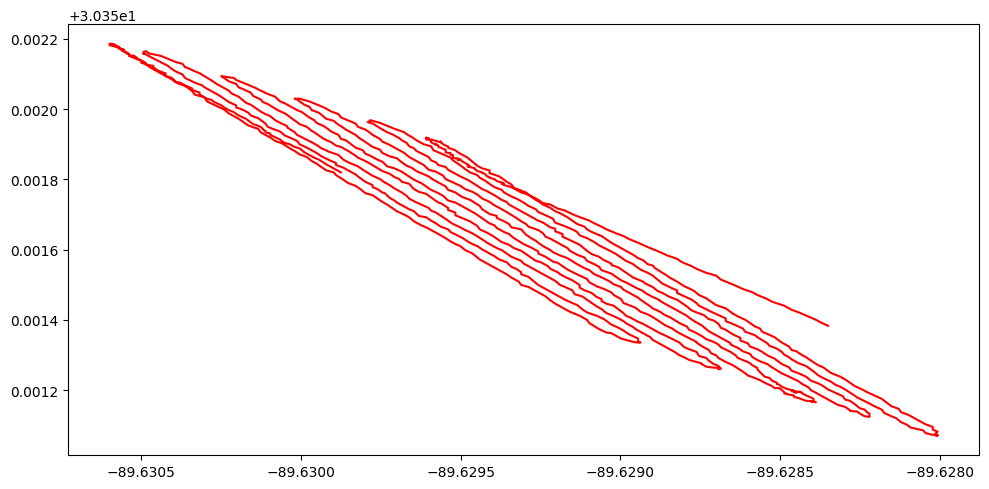

In [56]:
fig, ax = plt.subplots(1,1, figsize=(10, 5), tight_layout=True, dpi=100)
plt.plot(df_result['lng'], df_result['lat'], color = 'r')
# plt.plot(df_coor['lng'], df_coor['lat'], color = 'b')
plt.show()